In [1]:

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats
from scipy.stats import linregress

import cftime


In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
"ERA-Interim": 
    Dataset(
    short_name='tos',
    dataset='ERA-Interim',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20190101",
    tier=3)
}

In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

InputFilesNotFound: No files were found for Dataset:
{'dataset': 'ACCESS-ESM1-5',
 'project': 'CMIP6',
 'mip': 'Omon',
 'short_name': 'tos',
 'activity': 'CMIP',
 'ensemble': 'r1i1p1f1',
 'exp': 'historical',
 'frequency': 'mon',
 'grid': 'gn',
 'institute': ['CSIRO'],
 'long_name': 'Sea Surface Temperature',
 'modeling_realm': ['ocean'],
 'original_short_name': 'tos',
 'standard_name': 'sea_surface_temperature',
 'timerange': '19790101/20190101',
 'units': 'degC'}
session: 'session-bc505219-251c-4d4f-b36b-2ee8ccf369f2_20241101_014206'
locally using glob patterns:
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/tos/gn/*/tos_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn*.nc
/g/data/oi10/replicas/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/tos/gn/*/tos_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn*.nc
/g/data/xp65/public/apps/esmvaltool/replicas/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/tos/gn/*/tos_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn*.nc
/g/data/zv30/cmip/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/tos/gn/*/tos_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn*.nc

In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris

In [6]:
def prepoc(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = area_statistics(cube,operator='mean')
#    cube = extract_month(cube,12) # get DEC
    return cube

In [7]:
model_datasets_prep = {name: prepoc(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: prepoc(dataset) for name, dataset in obs_datasets.items()}


In [9]:
model_n34 = model_datasets_prep["ACCESS-ESM1-5"]
model_n34_dec = extract_month(model_datasets_prep["ACCESS-ESM1-5"],12)


In [11]:
# Create a CubeList with both cubes
combined_cubes = iris.cube.CubeList([model_n34, model_n34_dec])

# Save the CubeList to a single NetCDF file
output_filepath = '/g/data/p66/ars599/Hackathon/ENSO_recipes/n34_lifecycle_combined.nc'
#iris.save(combined_cubes, output_filepath, netcdf_format="NETCDF4")

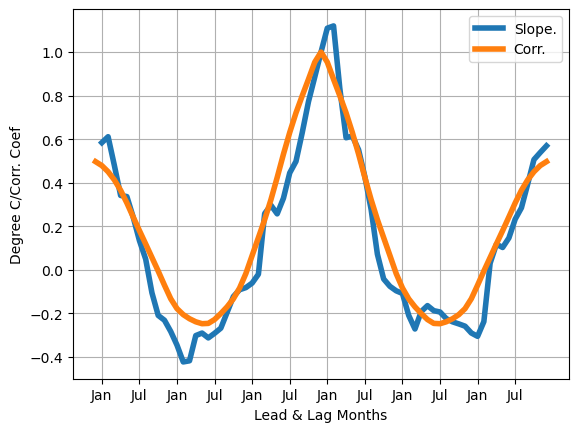

In [15]:
import xarray as xr
ds = xr.open_dataset(output_filepath)

leadlagyr = 2
n34 = ds['tos'].squeeze()
#n34_dec = n34[11::12]
n34_dec = ds['tos_0'].squeeze()
n34_dec_ct = n34_dec[leadlagyr:-leadlagyr-1]

event_years = n34_dec_ct.time_0.dt.year

# Create an empty array to store the years of interest
years_of_interest_array = np.empty((len(event_years), leadlagyr*3), dtype=int)

# Fill the array with the years of interest for each event year
for i, year in enumerate(event_years):
    # Ensure that the selected years are not the last or second last year in the n34 dataset
    years_of_interest_array[i] = [year.values - 2, year.values - 1, year.values, year.values + 1, year.values + 2, year.values + 3]


n34_selected = []

for i in range(len(years_of_interest_array)):
    # Select the data for the current year and append it to n34_selected
    n34_selected.append(n34.sel(time=n34['time.year'].isin(years_of_interest_array[i])))



import sacpy as scp

def autoCorrelation(x, lags):
    N = len(x)
    auto_corr = np.correlate(x, x, mode='full')
    assert N >= lags - 1
    auto_corr = auto_corr[N - lags - 1: N + lags]
    auto_corr = auto_corr / np.max(auto_corr)
    return auto_corr

n34_selected_array = np.array(n34_selected)  # Convert the list to a NumPy array
slope = scp.LinReg( n34_dec_ct.values, n34_selected_array).slope

acf1 = autoCorrelation(n34, 36)

# Define the lead/lag months
months = np.arange(1, 73) - 36
plt.plot(np.arange(1, 73) - 36, slope, label='Slope.', lw=4)
plt.plot(np.arange(1, 74) - 37, acf1, label='Corr.', lw=4)

"""
follow lifecycle need to change to jan jul ...

"""
# Define custom ticks for the x-axis (every 6 months)
xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)

plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C/Corr. Coef')
#plt.title('Plot Title')
plt.legend(); plt.grid()
# Apply the custom ticks and labels to the x-axis
plt.xticks(xticks, xtick_labels)
#plt.savefig('enso_n34_reg_ssta.png', bbox_inches='tight')
plt.show()